<a href="https://colab.research.google.com/github/nparslow/disfluency_gen/blob/develop/docs/tutorials/nmt_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# refactored and adapted from:
#https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb

import os
import sys
repoRoot = os.path.abspath(os.path.join(os.getcwd(), '..'))

# for local running without installing the package:
sys.path.append(os.path.join(repoRoot, "src"))

import tensorflow as tf
from disfluency_generator.data_preparation import load_data, create_dataset, print_examples, \
     tf_lower_and_split_punct, create_text_processor
from disfluency_generator.encoder import Encoder
from disfluency_generator.decoder import Decoder
from disfluency_generator.trainTranslator import TrainTranslator, BatchLogs
from disfluency_generator.maskedLoss import MaskedLoss
from disfluency_generator.translator import Translator
from disfluency_generator.trainTranslator import TrainTranslator

import pathlib

from disfluency_generator.letsread_prepare_translations import LetsReadDataPrep
from disfluency_generator.portuguese_phoneme_to_grapheme import PhonemeToGrapheme

print("Checking the GPU is accessible:")
print(tf.config.list_physical_devices('GPU'))


Checking the GPU is accessible:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# load data
data_path = pathlib.Path(repoRoot, "data")
verbose = 1
#------------------
letsread_corpus_path = os.path.join(data_path, "LetsReadDB")

p2g = PhonemeToGrapheme(os.path.join(repoRoot, "resources", "sampa.tsv"))
data_prep = LetsReadDataPrep(letsread_corpus_path, p2g)
_, _ = data_prep.prep_letsread()

(train_inputs, train_targets), (test_inputs, test_targets) = data_prep.train_test_split()


if verbose > 0:
    print(f"Last example of data:\n{train_inputs[-1]}\n{train_targets[-1]}")

# we'll leave off the first 20 as a test set (todo improve)
# reduce batch size wrt original set up as less data, this does make training a bit more noisy though
dataset = create_dataset(train_inputs, train_targets, BATCH_SIZE=64//2)

if verbose > 0:
    print("")
    print("Printing Examples (before normalisation):")
    print_examples(dataset, 5)


Cannot parse t6j~ at ~
Cannot parse lun6w at w
Cannot parse fi...ka...@ju at ju
Cannot parse kumunica at ca
Cannot parse gOc6~w~ at c6~w~
Cannot parse tevulz6w~ at w~
Cannot parse sÂj~ at Âj~
Likely typo: [l"a:du
Likely typo: [i~v@rn"ar
Cannot parse k6ir6w~ at w~
Last example of data:
flole mocla ambife dantrar mever
flole mocla ambife dantrar e mever

Printing Examples (before normalisation):
Por isso, quando o Homem pôs pela primeira vez os pés no solo lunar, a Lua sentiu-se, ao mesmo tempo, alegre e triste.
por isso quando o quando o homem pôs pela primeira vez os pés nuc no col lunar a lua sentiu-se ao mesmo tempo alegre e triste
--------------------
A Victória adorava guloseimas e um dia encontrou a árvore dos rebuçados.
a victória adorava guloseimas e um dia encontrou a arve durs dos rebuçados
--------------------
Em todos a porta era alta, mas o teto era baixo e Gira Gira tinha de estar de joelhos, porque não podia cortar o pescoço.
em todos a porta era alta mas o teto era baixo

/home/nickp/Documents/tutorials/disfluency_generator/src/disfluency_generator/letsread_prepare_translations.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lambda x: tf_lower_and_split_punct(x).numpy().decode())
/home/nickp/Documents/tutorials/disfluency_generator/src/disfluency_generator/letsread_prepare_translations.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Prompt_Start"] = filtered_df["Prompt_Norm"].str[8:18]


In [3]:

# todo - check with corpus:
max_vocab_size = 2917

input_text_processor = create_text_processor(train_inputs, max_vocab_size)

if verbose > 0:
    # todo better checking:
    print("First 10 words of input vocab:")
    print(input_text_processor.get_vocabulary()[:10])

# note - we don't have to have the same output vocab size:
output_text_processor = create_text_processor(train_targets, max_vocab_size)

if verbose > 0:
    print("First 10 words of target vocab:")
    print(output_text_processor.get_vocabulary()[:10])

if verbose > 0:
    for example_input_batch, example_target_batch in dataset.take(1):
        print("Example input token sequences (indices):")
        example_tokens = input_text_processor(example_input_batch)
        print(example_tokens[:3, :10])


First 10 words of input vocab:
['', '[UNK]', '[START]', '[END]', 'a', 'e', 'o', 'de', 'que', 'um']
First 10 words of target vocab:
['', '[UNK]', '[START]', '[END]', 'a', 'e', 'o', 'de', 'que', 'um']
Example input token sequences (indices):
tf.Tensor(
[[   2    6 2711 2627   48 2543    8    4  277  296]
 [   2    9 1543    7  420 1560    3    0    0    0]
 [   2 1994 1637 2121    5 1433    3    0    0    0]], shape=(3, 10), dtype=int64)


Before getting into it define a few constants for the model:

In [7]:
# The original model was built on more data, we shrink things down for the letsread corpus 
embedding_dim = 256//4
units = 1024//4

### Train the model


In [8]:

batch_loss = BatchLogs('batch_loss')

In [9]:

train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.002),  # default learning_rate = 0.001
    loss=MaskedLoss(),
)


In [10]:
# learning rate high at first:
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [11]:
train_translator.fit(dataset, epochs=30,
                     callbacks=[batch_loss, learning_rate_scheduler])

Epoch 1/30
71/71 [==============================] - 20s 218ms/step - batch_loss: 6.0405
Epoch 2/30
71/71 [==============================] - 16s 221ms/step - batch_loss: 5.6382
Epoch 3/30
71/71 [==============================] - 16s 217ms/step - batch_loss: 5.4185
Epoch 4/30
71/71 [==============================] - 16s 228ms/step - batch_loss: 5.2203
Epoch 5/30
71/71 [==============================] - 18s 247ms/step - batch_loss: 5.0421
Epoch 6/30
71/71 [==============================] - 19s 274ms/step - batch_loss: 4.8400
Epoch 7/30
71/71 [==============================] - 19s 261ms/step - batch_loss: 4.5956
Epoch 8/30
71/71 [==============================] - 19s 266ms/step - batch_loss: 4.3836
Epoch 9/30
71/71 [==============================] - 18s 256ms/step - batch_loss: 4.1884
Epoch 10/30
71/71 [==============================] - 19s 260ms/step - batch_loss: 3.9924
Epoch 11/30
71/71 [==============================] - 19s 262ms/step - batch_loss: 3.7699
Epoch 12/30
71/71 [===========

Text(0, 0.5, 'CE/token')

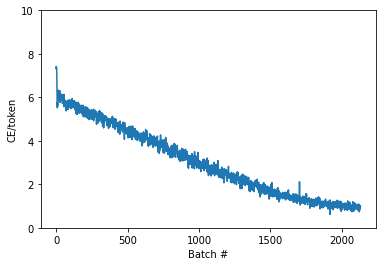

In [12]:
import matplotlib.pyplot as plt
plt.plot(batch_loss.logs)
plt.ylim([0, 10])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [13]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [14]:
model_name = 'portugues_trial_8'
tf.saved_model.save(translator, model_name,
                    signatures={'serving_default': translator.tf_translate})


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: portugues_trial_8/assets


INFO:tensorflow:Assets written to: portugues_trial_8/assets


In [15]:
model_name = 'portugues_trial_8'
reloaded = tf.saved_model.load(model_name)


In [16]:
# seems to be much more stable now - 
# definitely way overfitting - need to bring in early stopping or a dev set

test_sentences = tf.constant(test_inputs)  # from prompts not used in training 
result = reloaded.tf_translate(test_sentences[:10])

print("On held out test sentences:")
for orig, tr in zip(test_sentences, result['text']):
    print(orig.numpy().decode())
    print(tr.numpy().decode())
    print("------------")

print()


print("On training sentences:")

train_sentences = tf.constant(train_inputs[:10])
result = reloaded.tf_translate(test_sentences)

for orig, tr in zip(test_sentences, result['text']):
    print(orig.numpy().decode())
    print(tr.numpy().decode())
    print("------------")

print()

On held out test sentences:
O rapazinho adorava o cheiro da maresia.
o ratito adorava bebe tudo bicicleta
------------
O rapazinho adorava o cheiro da maresia.
o osso dos acessivel a roda a sua ramajaims
------------
Em frente da casa do Sérgio mora um violinista famoso.
um rato da janela ha uma hera logo o ar havia luis tudo alem
------------
Em frente da porta da casa havia um grande pinheiro.
ele ele e todos os mao irreal visse a ro todos a segunda de sua todos la la para la
------------
Certo dia, quando estava a varrer a cozinha, encontrou uma moeda de cinco réis.
quatro os meses as rastos tanto mas ali no momento todos que esta tinha estrelas ramos para o ar
------------
O menino encontrou o vento do norte.
o joao chegou a historia de andavam por noventa hora antes
------------
Em frente da casa do Sérgio mora um violinista famoso.
pos o fato de leiria os visse se o fe leva a terra de esta mais sair
------------
Em frente da porta da casa havia um grande pinheiro.
iscitada e e to